https://www.kaggle.com/c/bike-sharing-demand/data?select=train.csv

# 자전거 대여량 예측 모델 

In [25]:
# LinearRegression,RandomForestRegressor
# GradientBoostingRegressor, XGBRegressor, LGBMRegressor

datetime - 년-월-일-24시간   
season -  1 = 봄, 2 = 여름, 3 = 가을, 4 = 겨울   
holiday - 해당 요일이 휴일인지 여부. 0 = 평일(no), 1 = 휴일(휴)     
workingday - 해당 요일이 주말이나 휴일이 아닌지 여부. 0 = 휴일(no), 1 = 평일(일)    
weather - 1: 맑음, 구름 약간, 부분적으로 구름, 부분적으로 구름   
2: 안개 + 구름, 안개 + 깨진 구름, 안개 + 구름 약간, 안개   
3: 가벼운 눈, 가벼운 비 + 뇌우 + 흩어진 구름, 가벼운 비 + 흩어진 구름   
4: 폭우 + 얼음판 + 뇌우 + 안개, 눈 + 안개    
temp - 섭씨 온도   
atemp - 체감 온도   
섭씨 humid - 상대 습도   
windspeed - 풍속    

casual - 등록된 사용자가 시작한 대여 수   
registered - 등록된 사용자가 시작한 대여 수   
count - 총 대여 수 

<br/>
<br/>

# 라이브러리 불러오기

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

<br/>
<br/>

# 데이터 확인
- 결측치 확인
- 이상치 확인
- 제거
- 상관관계 분석

In [27]:
df_train = pd.read_csv('C:/swcamp/hipython_rep/data/bike-sharing-demand/train.csv')

In [28]:
df_train.head(10)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
5,2011-01-01 05:00:00,1,0,0,2,9.84,12.880,75,6.0032,0,1,1
6,2011-01-01 06:00:00,1,0,0,1,9.02,13.635,80,0.0000,2,0,2
7,2011-01-01 07:00:00,1,0,0,1,8.20,12.880,86,0.0000,1,2,3
8,2011-01-01 08:00:00,1,0,0,1,9.84,14.395,75,0.0000,1,7,8
9,2011-01-01 09:00:00,1,0,0,1,13.12,17.425,76,0.0000,8,6,14


In [29]:
# 각 컬럼의 결측치 개수 확인
print(df_train.isnull().sum())

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64


In [30]:
# 이상치를 탐지할 수치형 피처 목록
# casual과 registered는 count를 구성하는 변수이므로 포함합니다.
numerical_features = ['temp', 'atemp', 'humidity', 'windspeed']

# 각 피처에 대해 이상치 탐지 및 제거
for col in numerical_features:
    # 1사분위수(Q1)와 3사분위수(Q3) 계산
    Q1 = df_train[col].quantile(0.25)
    Q3 = df_train[col].quantile(0.75)
    IQR = Q3 - Q1
    
    # 이상치 경계 계산
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # 이상치를 벗어나는 행의 개수 출력
    outlier_count = np.sum((df_train[col] < lower_bound) | (df_train[col] > upper_bound))
    print(f"'{col}' 컬럼의 이상치 개수: {outlier_count}개")
    
    # 이상치를 제거하고 데이터프레임 업데이트
    df_new = df_train[(df_train[col] >= lower_bound) & (df_train[col] <= upper_bound)]

'temp' 컬럼의 이상치 개수: 0개
'atemp' 컬럼의 이상치 개수: 0개
'humidity' 컬럼의 이상치 개수: 22개
'windspeed' 컬럼의 이상치 개수: 227개


In [31]:
print("\n 이상치 제거 후")
print("원본 데이터프레임 shape:", df_train.shape)
print("이상치 제거 후 데이터프레임 shape:", df_new.shape)


 이상치 제거 후
원본 데이터프레임 shape: (10886, 12)
이상치 제거 후 데이터프레임 shape: (10659, 12)


In [32]:
df_new

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129


C:\Users\jjaga\AppData\Local\Temp\ipykernel_21996\2798349113.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 0].set_xticklabels(['Spring', 'Summer', 'Fall', 'Winter'])
C:\Users\jjaga\AppData\Local\Temp\ipykernel_21996\2798349113.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 1].set_xticklabels(['Weekday', 'Holiday'])
C:\Users\jjaga\AppData\Local\Temp\ipykernel_21996\2798349113.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, 0].set_xticklabels(['Holiday/Weekend', 'Working Day'])
C:\Users\jjaga\AppData\Local\Temp\ipykernel_21996\2798349113.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, 1].set_xticklabels(

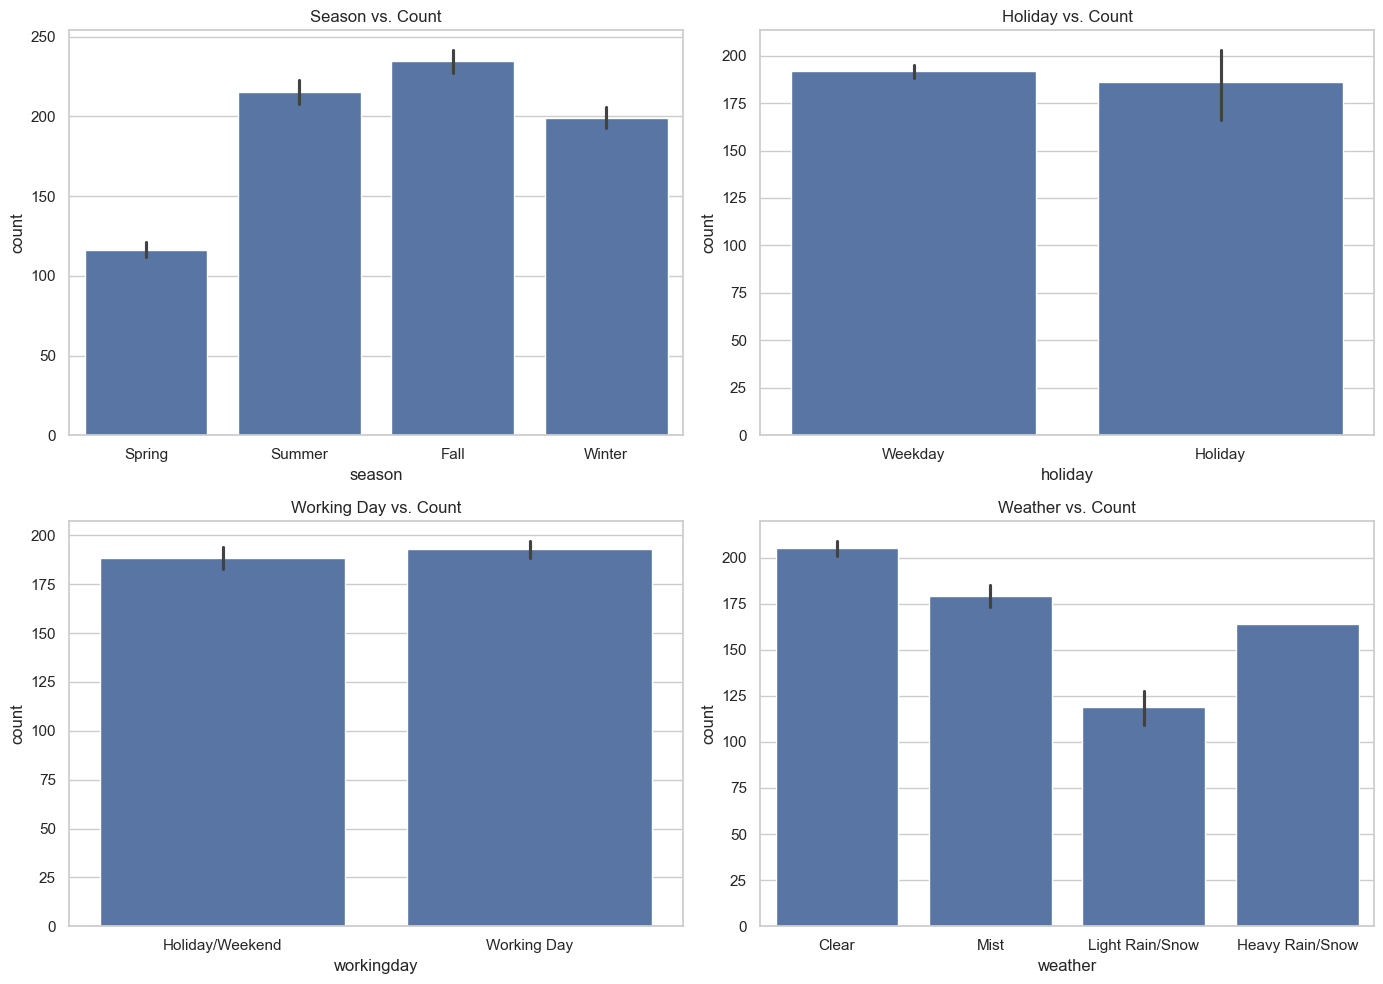

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

# 그래프 스타일 설정
sns.set(style="whitegrid")

# season, holiday, workingday, weather 별 count 평균 막대그래프
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

sns.barplot(data=df_train, x="season", y="count", ax=axes[0, 0])
axes[0, 0].set_title('Season vs. Count')
axes[0, 0].set_xticklabels(['Spring', 'Summer', 'Fall', 'Winter'])

sns.barplot(data=df_train, x="holiday", y="count", ax=axes[0, 1])
axes[0, 1].set_title('Holiday vs. Count')
axes[0, 1].set_xticklabels(['Weekday', 'Holiday'])

sns.barplot(data=df_train, x="workingday", y="count", ax=axes[1, 0])
axes[1, 0].set_title('Working Day vs. Count')
axes[1, 0].set_xticklabels(['Holiday/Weekend', 'Working Day'])

sns.barplot(data=df_train, x="weather", y="count", ax=axes[1, 1])
axes[1, 1].set_title('Weather vs. Count')
axes[1, 1].set_xticklabels(['Clear', 'Mist', 'Light Rain/Snow', 'Heavy Rain/Snow'])

plt.tight_layout()
plt.show()

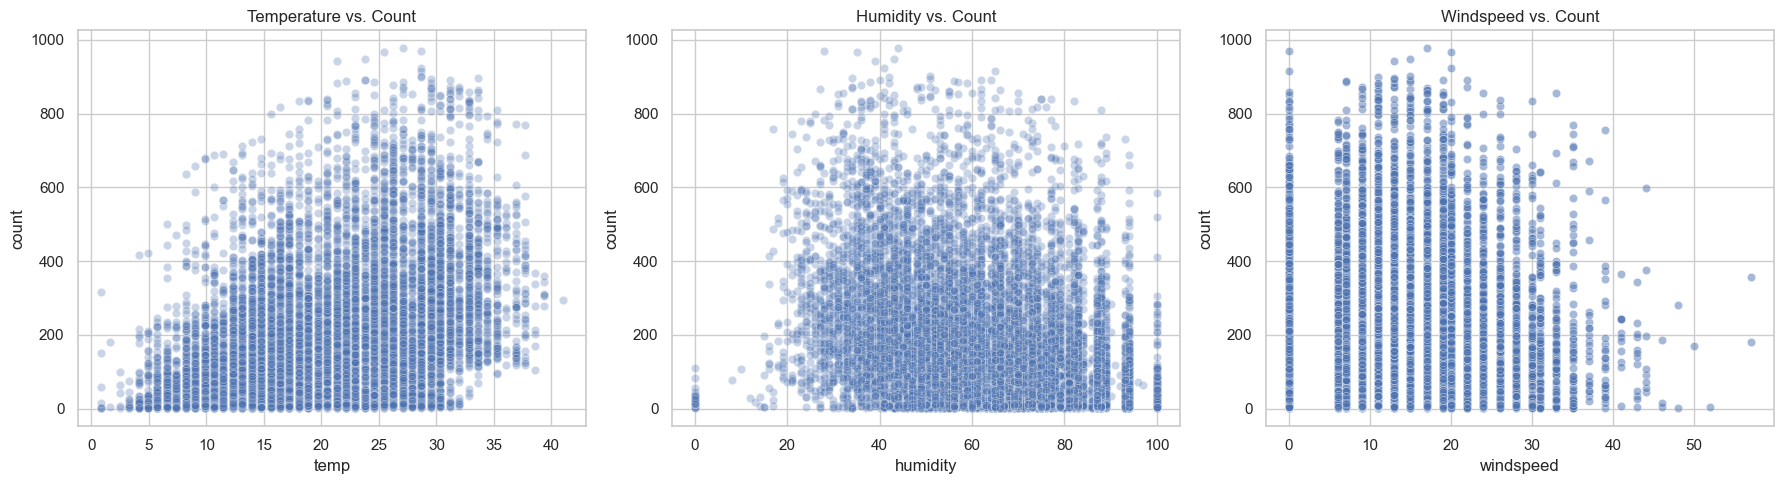

In [34]:
# temp, humidity, windspeed 별 count 산점도
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.scatterplot(data=df_train, x="temp", y="count", ax=axes[0], alpha=0.3)
axes[0].set_title('Temperature vs. Count')

sns.scatterplot(data=df_train, x="humidity", y="count", ax=axes[1], alpha=0.3)
axes[1].set_title('Humidity vs. Count')

sns.scatterplot(data=df_train, x="windspeed", y="count", ax=axes[2], alpha=0.5)
axes[2].set_title('Windspeed vs. Count')

plt.tight_layout()
plt.show()

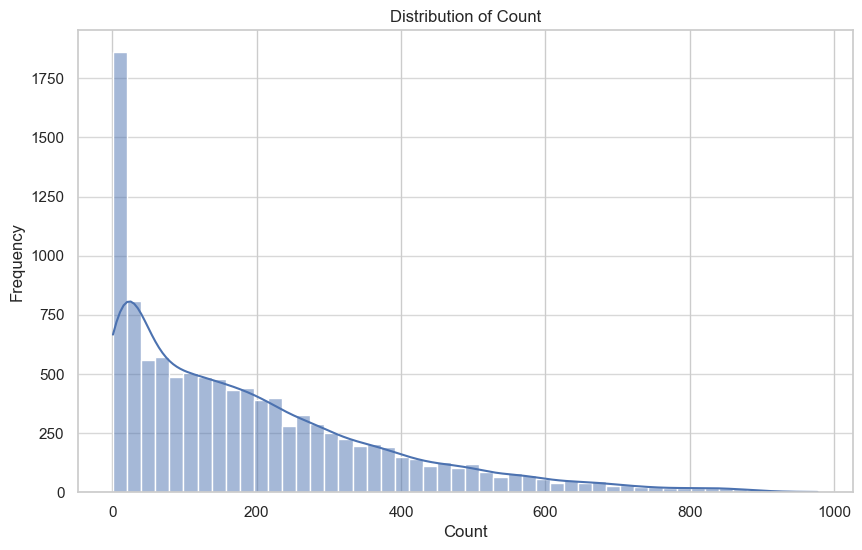

In [35]:
# 'count' 컬럼의 히스토그램 그리기
plt.figure(figsize=(10, 6)) # 그래프 크기 설정
sns.histplot(df_train['count'], bins=50, kde=True) # bins는 막대 개수, kde=True는 밀도 추정 곡선 추가
plt.title('Distribution of Count') # 그래프 제목
plt.xlabel('Count') # x축 레이블
plt.ylabel('Frequency') # y축 레이블
plt.grid(axis='y', alpha=0.75) # y축에 그리드 추가
plt.show() # 그래프 보여주기

강한 오른쪽 꼬리
값이 낮은 구간에 집중되어 있음을 의미한다.
분포의 비대칭성을 고려해서 로그 변환이 필요할 것 같다.

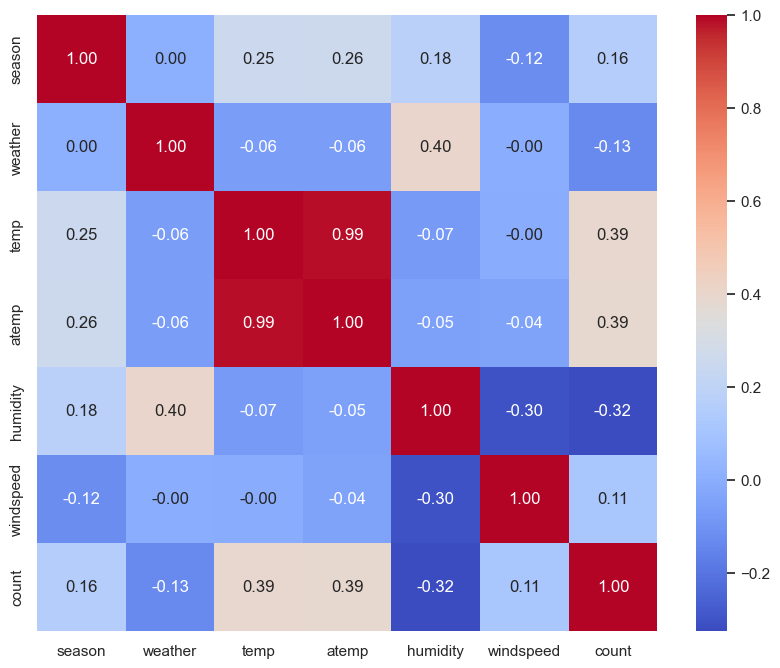

In [36]:
corr = df_new[['season','weather','temp', 'atemp', 'humidity', 'windspeed', 'count']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.show()

temp는 atemp와 비슷하다.

<br/>
<br/>

# 데이터 전처리

In [37]:
df_new = df_new.drop(['casual', 'registered'], axis=1)

In [38]:
# 2. datetime 처리
df_new['datetime'] = pd.to_datetime(df_new['datetime'])
df_new['year'] = df_new['datetime'].dt.year
df_new['month'] = df_new['datetime'].dt.month
df_new['day'] = df_new['datetime'].dt.day
df_new['hour'] = df_new['datetime'].dt.hour
df_new['dayofweek'] = df_new['datetime'].dt.dayofweek
df_new.drop('datetime', axis=1, inplace=True)

In [39]:
df_new

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour,dayofweek
0,1,0,0,1,9.84,14.395,81,0.0000,16,2011,1,1,0,5
1,1,0,0,1,9.02,13.635,80,0.0000,40,2011,1,1,1,5
2,1,0,0,1,9.02,13.635,80,0.0000,32,2011,1,1,2,5
3,1,0,0,1,9.84,14.395,75,0.0000,13,2011,1,1,3,5
4,1,0,0,1,9.84,14.395,75,0.0000,1,2011,1,1,4,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,4,0,1,1,15.58,19.695,50,26.0027,336,2012,12,19,19,2
10882,4,0,1,1,14.76,17.425,57,15.0013,241,2012,12,19,20,2
10883,4,0,1,1,13.94,15.910,61,15.0013,168,2012,12,19,21,2
10884,4,0,1,1,13.94,17.425,61,6.0032,129,2012,12,19,22,2


<br/>
<br/>

# 모델 만들기

데이터 나누기

In [69]:
X = df_new.drop('count', axis=1)
y = df_new['count'].values
df_new.shape

(10659, 14)

스케일러 객체 생성

In [70]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [71]:
df_new.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour,dayofweek
0,1,0,0,1,9.84,14.395,81,0.0,16,2011,1,1,0,5
1,1,0,0,1,9.02,13.635,80,0.0,40,2011,1,1,1,5
2,1,0,0,1,9.02,13.635,80,0.0,32,2011,1,1,2,5
3,1,0,0,1,9.84,14.395,75,0.0,13,2011,1,1,3,5
4,1,0,0,1,9.84,14.395,75,0.0,1,2011,1,1,4,5


선형 회귀 모델 만들고 학습, 예측

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=156)
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
y_pred[:3]

array([146.62802313,  94.91655338,   5.39572912])

MSE (Mean Squared Error, 평균제곱오차)   
RMSE (Root Mean Squared Error, 평균제곱근오차)   
결정계수 R2

In [73]:
# 평가
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print(f'MSE : {mse}\nRMSE : {rmse}\nR2:{r2}')

MSE : 20683.881391765248
RMSE : 143.81891875468
R2:0.3784422974502508


회귀식   
 lr.intercept_ : 절편
 lr.coef_ : 각 변수의 계수

 b (intercept_): 절편, 모든 입력값이 0일 때 y의 예측값.

w_i (coef_): 각 입력 변수의 계수(기울기), 입력 변수 x_i가 y에 미치는 영향력.

In [74]:
# 회귀식 
# W1, W0
lr.intercept_, lr.coef_

(np.float64(-169909.4382194687),
 array([-3.17968255, -0.89319018,  5.0789487 , -2.89185963,  2.33357825,
         3.8558373 , -2.06157056,  0.85212314, 84.48253723,  8.1682275 ,
         0.39127787,  7.85289757,  1.26472507]))

In [75]:
np.round(lr.intercept_, 1), np.round(lr.coef_,1)

(np.float64(-169909.4),
 array([-3.2, -0.9,  5.1, -2.9,  2.3,  3.9, -2.1,  0.9, 84.5,  8.2,  0.4,
         7.9,  1.3]))

각 특성(컬럼)과 목표 변수의 관계 확인   

값이 클수록 y(목표 변수)에 큰 영향을 미침.

양수(+) 계수: 해당 변수가 커지면 y도 증가.

음수(-) 계수: 해당 변수가 커지면 y는 감소.

In [76]:
pd.Series(data = np.round(lr.coef_,1), 
          index=df_new.drop('count', axis=1).columns).sort_values(ascending=False)

year          84.5
month          8.2
hour           7.9
workingday     5.1
atemp          3.9
temp           2.3
dayofweek      1.3
windspeed      0.9
day            0.4
holiday       -0.9
humidity      -2.1
weather       -2.9
season        -3.2
dtype: float64

year, month, hour, workingday,atemp, season 관계가 크다.

교차검증

In [77]:
from sklearn.model_selection import cross_val_score
neg_mse_scores = cross_val_score(lr, X, y, scoring='neg_mean_squared_error', cv=5)
neg_mse_scores

array([-10908.19464062, -14686.77731091, -13719.53942697, -33078.64128837,
       -33793.6269969 ])

In [78]:
# MSE, RMSE
RMSE = np.sqrt(neg_mse_scores*-1)
np.mean(RMSE), np.round(RMSE)

(np.float64(141.69350617480916), array([104., 121., 117., 182., 184.]))

In [79]:
#R2
r2_scores = cross_val_score(lr, X, y, scoring='r2', cv=5)
r2_scores, np.mean(r2_scores)

(array([-0.04624133,  0.34181158,  0.16732141,  0.29074747,  0.28624175]),
 np.float64(0.20797617277373792))

--- 

<br/>
<br/>

# 모델 만들기

In [58]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

다항 회귀 모델

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=156)
model_poly = Pipeline([
  ('poly', PolynomialFeatures(degree=4, include_bias=False)),
  ('linear', LinearRegression())]
)
model_poly.fit(X_train, y_train)

Pipeline(steps=[('poly', PolynomialFeatures(degree=4, include_bias=False)),
                ('linear', LinearRegression())])

In [81]:
results = []
best_r2=-np.inf
best_model = None
best_pred = None

for degree in range(1,5):
  model_poly = Pipeline([
    ('poly', PolynomialFeatures(degree=degree, include_bias=False)),
    ('linear', LinearRegression())]
  )
  model_poly.fit(X_train, y_train)
  pred_poly = model_poly.predict(X_test)
  mse = mean_squared_error(y_test, pred_poly)
  rmse = np.sqrt(mse)
  r2 = r2_score(y_test, pred_poly)
  
  results.append({ 'degree':degree,
                  'MSE':mse,
                  'RMSE':rmse,
                  'R2': r2})
  if r2> best_r2:
    best_r2 = r2
    best_model = model_poly
    best_pred = pred_poly
    
pd.DataFrame(results)

,degree,MSE,RMSE,R2
0,1,20683.881392,143.818919,0.378442
1,2,15303.987342,123.709286,0.540110
2,3,12826.599076,113.254576,0.614556
3,4,237323.197971,487.158288,-6.131643


규제 회귀 모델
- Ridge
- Losso
- ElasticNet

In [64]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet

In [ ]:
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
pred_ridge = ridge.predict(X_test)

mse = mean_squared_error(y_test, pred_ridge)
r2  = r2_score(y_test, pred_ridge)
mse, r2

In [66]:
from sklearn.linear_model import RidgeCV, LassoCV
alphas = [0.001, 0.01, 0.1, 1, 10, 100]
ridge_cv = RidgeCV(alphas=alphas, cv=5)